In [1]:
from IPython.display import Markdown, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse as sp

%matplotlib inline
import seaborn as sns
import math
import itertools
from sklearn import mixture
import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.manifold import Isomap
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans as KMeanspkg
from sklearn.decomposition import FastICA 
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import MDS
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import time
import umap
import hdbscan
from scipy import linalg
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score

def printmd(string):
    display(Markdown(string))

In [2]:
#'/users/PAS1376/karkhanis6/Cytometry/Levine_32dim.txt'
#'/users/PAS1376/bg12/DGCyTOF_Feedback1'
dim_32 = pd.read_csv('/users/PAS1376/bg12/DGCyTOF_Feedback1/Levine_32dim.txt', sep = "\t", header=0)
dim_32.head()

,Time,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,...,CD117,CD49d,HLA-DR,CD64,CD41,Viability,file_number,event_number,label,individual
0,1024,22,4.391057,4.617262,0.162691,-0.029585,-0.006696,0.066388,-0.009184,0.363602,...,0.053050,0.853505,1.664480,-0.005376,-0.001961,0.648429,3.627711,307,1.0,1
1,1024,35,4.340481,4.816692,0.701348,-0.038280,-0.016654,0.074409,0.808031,-0.035424,...,0.089660,0.197818,0.491592,0.144814,0.868014,0.561384,3.627711,545,1.0,1
2,1024,32,3.838727,4.386369,0.603568,-0.032216,0.073855,-0.042977,-0.001881,-0.008781,...,0.046222,2.586670,1.308337,-0.010961,-0.010413,0.643337,3.627711,1024,1.0,1
3,1024,29,4.255805,4.830048,0.433747,-0.027611,-0.017661,-0.044072,0.733698,-0.019066,...,0.066470,1.338669,0.140523,-0.013449,-0.026039,-0.026523,3.627711,1024,1.0,1
4,1024,25,3.976909,4.506433,-0.008809,-0.030297,0.080423,0.495791,1.107627,0.552746,...,-0.006223,0.180924,0.197332,0.076167,-0.040488,0.283287,3.627711,1024,1.0,1


### Filtering labeled and unlabeled data

In [3]:
columns_to_remove = ['Time', 'Cell_length', 'DNA1', 'DNA2', 'Viability', 'file_number', 'event_number', 'individual']
dim_32 = dim_32.drop(columns_to_remove, axis = 1)

In [4]:
dim_32_labeled = dim_32[dim_32.label.notnull()]     # Labeled data
dim_32_labeled_data = dim_32_labeled[dim_32_labeled.columns[dim_32_labeled.columns != 'label']] # labeled data without labels
dim_32_labels = dim_32_labeled['label']    # labels of labeled data

In [5]:
dim_32_unlabeled_data = dim_32[dim_32.label.isnull()]   # unlabeled data
del dim_32_unlabeled_data['label']                      # deleting 'label' column of unlabeled data

In [6]:
classes = ['Basophils', 'CD16-_NK_cells', 'CD16+_NK_cells', 'CD34+CD38+CD123-_HSPCs', 'CD34+CD38+CD123+_HSPCs', 
           'CD34+CD38lo_HSCs', 'CD4_T_cells', 'CD8_T_cells', 'Mature_B_cells', 'Monocytes', 'pDCs', 'Plasma_B_cells',
           'Pre_B_cells', 'Pro_B_cells']

# Validation Data

In [7]:
validation_data = pd.read_csv('/users/PAS1376/karkhanis6/Cytometry/Semi_Clustering/32dim/40-60_Balanced_Model_&_Data/0.6_validation_data.txt')

In [8]:
validation_samples = validation_data.drop(['label'], axis = 1) 
validation_labels = validation_data['label']    

## Functions for different Dimensionality Reduction Techniques, Ploting of reduced dimensional data, adding cluster (label) column in the newly created dataframe

In [9]:
def pca(data, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(data)
    data_pca = pca.transform(data)
    return data_pca
        
def ica(data, n_components):
    ica = FastICA(n_components = n_components)
    data_ica = ica.fit_transform(data)
    return data_ica
        
def fa(data, n_components):
    fa = FactorAnalysis(n_components = n_components, max_iter=5000)
    data_fa = fa.fit_transform(data)
    return fa, data_fa
        
def svd(data, n_components):
    svd = TruncatedSVD(n_components = n_components)
    data_svd = svd.fit_transform(data)
    return data_svd
        
def mds(data, n_components):
    mds = MDS(n_components = n_components)
    data_mds = mds.fit_transform(data)
    return data_mds

def tsne(data, n_components):
    tsne = TSNE(n_components = n_components)
    data_tsne = tsne.fit_transform(data)
    return data_tsne

def u_map(data, n_components):
    u_map = umap.UMAP(n_components = n_components)
    data_umap = u_map.fit_transform(data)
    return data_umap

def isomap(data, n_components):
    isomap = Isomap(n_components = n_components)
    data_isomap = isomap.fit_transform(data)
    return data_isomap
        
def Dim_Red_Plot (data, labels):
    '''
    data = reduced dim data
    labels =  labels of data  
    '''
    plt.figure(figsize=(10,6))
    plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], s=8, cmap='nipy_spectral', c=labels, alpha=0.5)
    cbar = plt.colorbar(boundaries=np.arange(15)-0.5)
    cbar.set_ticks(np.arange(14))
    cbar.set_ticklabels(classes)

    plt.xlabel('component 1')
    plt.ylabel('component 2')

def addcluster(data, labels):
    data = pd.DataFrame(data)
    data.columns = ['1d','2d']
    labeled_data = data.copy()
    labeled_data['cluster'] = labels.astype('int64')
    return labeled_data

## Creating Clusters using K-Means
###  Finding Optimal Number of Clusters

There are two primary methods to define number of clusters:

- Elbow criterion (visual method)
  - Plot number of clusters against within-cluster sum-of-squared-errors (SSE) - sum of squared distances from every data point to their cluster center.

- Silhouette Score (math method)
  - Measures intra- and inter-cluster distance
  
Here I am using silhouette score to choose an optimal value for n_clusters.

###  Silhouette Score

- The Silhouette Score is from -1 to 1 and show how close or far away the clusters are from each other and how dense the clusters are. The closer your silhouette score is to 1 the more distinct your clusters are.
- If your score is 1 think of your clusters as perfect little balls that are far away from each other with no miss classification. Values near 0 indicate overlapping clusters.
- The Silhouette Coefficient is calculated using the mean intra-cluster distance $a$ and the mean nearest-cluster distance $b$ for each sample. 
- The Silhouette Coefficient for a sample is $\frac{b - a} {max(a, b)}$. To clarify, $b$ is the distance between a sample and the nearest cluster that the sample is not a part of. 
  - Note that Silhouette Coefficient is only defined if number of labels is $2 \leq n_{labels} \leq (n_{samples} - 1)$.  
- We used function **silhouette_score** to compute the mean Silhouette Coefficient of all samples.

###  Silhouette Plot

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters.

In [10]:
def silhouette_plot(data, range_n_clusters, lim_x, mat_size):
    #plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 4)
        ax1.set_xlim([lim_x[0], lim_x[1]])
        
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
        y_lower = 10
        
        kmeans = KMeanspkg(init='k-means++', n_clusters = n_clusters, n_init=30)
        clusters = kmeans.fit_predict(data)
        sample_silhouette_values = silhouette_samples(data, clusters)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(data, clusters)    
        
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            #color = cm.spectral(float(i) / n_clusters) facecolor=color, edgecolor=color,       
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
       
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10
            plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters), 
                          fontsize=14, fontweight='bold')
        print("For n_clusters =", n_clusters, '\n', "The average silhouette_score is :", silhouette_avg)
        plt.show()    

## Functions for KMeans, calculation of SSB and SSE
### SSB - Sum of Squares Between Different Clusters  
### SSE - Total Sum of Squares Within Each Cluster

In [11]:
# Functions of KMeans

def initializeCentroids(k, d, low = 0, high = 1):
    return np.random.uniform(low, high, size = (k,d))

def setClusters(data, centroids, euclidean):
    return np.apply_along_axis(euclidean, 1, data, centroids)


def euclideanRank(centroids, point, nsmall = 0):
    return rankCluster(np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = 1)), nsmall)

def euclideanDist(centroids, point):
    return np.sqrt( np.sum( np.power( np.subtract(centroids, point), 2), axis = len(centroids.shape)-1)) # Hack

def rankCluster(y, n):
    return np.argpartition(y, n)[n]+1

def updateCentroids(data, clusters, centroids):
    for i in range(centroids.shape[0]):
        if i+1 in clusters:
            centroids[i, ] = data[np.where(clusters == i+1), ].mean(axis = 1)
    return centroids

def nSmallestDistPoints(points, n):
    l = []
    for i in range(points.shape[0]):
        l = np.append(l, euclideanDist(points, points[i, ]))

    n *= 2
    ind = np.argpartition(l, points.shape[0] + n)[points.shape[0] + n]
    r = int(np.floor(ind / points.shape[0]))
    c = int(np.floor(ind % points.shape[0]))
    return r, c, l[ind]

def reallyreallyInitializeCentroids(data, k):
    centroids = data[np.random.randint(0, data.shape[0], k), ]
    replacement_counter = 0
    for i in range(data.shape[0]):
        case = data[i, ]
        closest1, closest2, dist = nSmallestDistPoints(centroids, 1)
        if np.min(euclideanDist(centroids, case)) > dist:
            if euclideanDist(centroids[closest1, ], case) > euclideanDist(centroids[closest2, ], case):
                centroids[closest2, ] = case
            else:
                centroids[closest1, ] = case
            replacement_counter += 1
        else:
            second_closest_case = np.argpartition(euclideanDist(centroids, case), 1)[1]
            first_closest_case = np.argpartition(euclideanDist(centroids, case), 0)[0]
            closest_to_second_closest_case = np.argpartition(euclideanDist(centroids, centroids[second_closest_case, ]), 1)[1]
            #closest1, closest2, dist = nSmallestDistPoints(centroids, 2)

            if np.partition(euclideanDist(centroids, case), 1)[1] > euclideanDist(centroids[second_closest_case, ], centroids[closest_to_second_closest_case, ]):
                centroids[first_closest_case, ] = case
                replacement_counter += 1
    #print('Centroids replaced %d time(s).' % (replacement_counter))
    return centroids

def KMeansFormal(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    
    return pd.DataFrame({'RowID' : [i for i in range(len(clusters))], 'Cluster' : clusters})

def KMeans(k, data, centroids = None):
    if centroids is None:
        centroids = initializeCentroids(k, data.shape[1], data.min(), data.max())
    p_centroids = centroids - 1
    run_counter = 0
    while not (p_centroids == centroids).all():
        run_counter += 1
        p_centroids = centroids.copy()
        clusters = setClusters(data, centroids, euclideanRank)
        centroids = updateCentroids(data, clusters, centroids)
    return centroids, run_counter, clusters

def calculateMeasures(data, clusters, centroids):
    Total_SSW, SSB = 0, 0
    SSW_clusterwise = []
    for i in range(centroids.shape[0]):
        SSB += euclideanDist(np.mean(data, axis = 0), centroids[i]) * len(np.where(clusters == i+1)[0])
        cluster_filter = np.where(clusters == i+1)
        if len(cluster_filter[0]) == 0:
            temp = 0
        else:
            temp = np.sum(np.apply_along_axis(euclideanDist, 1, data[cluster_filter], centroids[i]))
        Total_SSW += temp
        SSW_clusterwise.append(temp)
        
    return Total_SSW, SSB, SSW_clusterwise

## Functions for kmeans, Spectral Clustering (off-the-shelves) and plotting of clusters

In [12]:
def kmeans_pkg(data, n_clusters):
    kmeans = KMeanspkg(n_clusters = n_clusters).fit(data)
    y_kmeans = kmeans.predict(data)
    centers = kmeans.cluster_centers_
    return y_kmeans, centers

def kmeans_plt (data, y_kmeans, centers):    
    plt.figure(figsize=(10,6))
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=8, cmap='nipy_spectral')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=40, alpha=0.5)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()
    
def spectralclustering(data, n_clusters):
    spectral = SpectralClustering(n_clusters = n_clusters).fit(data)
    y_spectral = spectral.predict(data)
    # centers = spectral.cluster_centers_
    return y_spectral

def spectral_plt (data, y_spectral):    
    plt.figure(figsize=(13,9))
    plt.scatter(data[:, 0], data[:, 1], c=y_spectral, s=50, cmap='nipy_spectral')
    # plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5)
    plt.show()
    
def Mixture_model(data, n_components):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(data)
    y_gmm = gmm.predict(data)
    return y_gmm

## Function for printing SSB and SSE of True clusters

In [13]:
def True_measures(data, labeled_data):
    printmd('### True Cluster Membership')
    Total_SSW, SSB, SSW_clusterwise = calculateMeasures(data, labeled_data.cluster.values,
                                          updateCentroids(data, labeled_data.cluster.values, 
                                                          np.zeros((14,data.shape[1]))))
    print('SSB : %f' % (SSB))
    print('Total_SSW : %f' % (Total_SSW))
    print('Cluster-wise SSW:')
    for i,x in enumerate(SSW_clusterwise):
        print('Cluster %d: %f' %(i+1, round(x,2)))

## Functions for printing SSB and SSE of newly created clusters 

In [14]:
def new_measures(data, n_clusters):
    centroids, iterations, clusters = KMeans(n_clusters, data)

    printmd('### Class membership when K = 14')
    Total_SSW, SSB, SSW_clusterwise = calculateMeasures(data, clusters, centroids)
    print('SSB : %f' % (SSB))
    print('Total_SSW : %f' % (Total_SSW))
    print('Cluster-wise SSW:')
    for i,x in enumerate(SSW_clusterwise):
        print('Cluster %d: %f' %(i+1, round(x,2)))

    print('\nIteration till convergence : %d' %(iterations))

## Function for Accuracy calculation with cluster_numbers (k) from 1 to 14

In [15]:
def accuracycalculation (data):
    accuracy =[]
    for i in range(1,15):
        kmeans = KMeanspkg(n_clusters = i).fit(data)
        y_kmeans = kmeans.predict(data)
        
        table = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans, name = 'Assigned Label'))
        
        Labelwise_accuracy = table.apply(lambda r: r.max()/r.sum(), axis =1).sum(axis = 0)*100/len(table)
        
        accuracy.append({'Accuracy': round(Labelwise_accuracy,2), '# Clusters': i})
    return pd.DataFrame(accuracy)

In [16]:
def accuracycalculation_gmm (data):
    accuracy =[]
    for i in range(1,15):
        gmm = mixture.GaussianMixture(n_components=i, covariance_type='full').fit(data)
        y_gmm = gmm.predict(data)
        
        table = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_gmm, name = 'Assigned Label'))
        
        Labelwise_accuracy = table.apply(lambda r: r.max()/r.sum(), axis =1).sum(axis = 0)*100/len(table)
        
        accuracy.append({'Accuracy': round(Labelwise_accuracy,2), '# Components': i})
    return pd.DataFrame(accuracy)

## Function for F1_measure

In [17]:
def contingency_matrix(labels_true, labels_pred, eps=None, sparse=False):
    """Build a contingency matrix describing the relationship between labels.
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
        Ground truth class labels to be used as a reference
    labels_pred : array, shape = [n_samples]
        Cluster labels to evaluate
    eps : None or float, optional.
        If a float, that value is added to all values in the contingency
        matrix. This helps to stop NaN propagation.
        If ``None``, nothing is adjusted.
    sparse : boolean, optional.
        If True, return a sparse CSR continency matrix. If ``eps is not None``,
        and ``sparse is True``, will throw ValueError.

    Returns
    -------
    contingency : {array-like, sparse}, shape=[n_classes_true, n_classes_pred]
        Matrix :math:`C` such that :math:`C_{i, j}` is the number of samples in
        true class :math:`i` and in predicted class :math:`j`. If
        ``eps is None``, the dtype of this array will be integer. If ``eps`` is
        given, the dtype will be float.
        Will be a ``scipy.sparse.csr_matrix`` if ``sparse=True``.
    """

    if eps is not None and sparse:
        raise ValueError("Cannot set 'eps' when sparse=True")

    classes, class_idx = np.unique(labels_true, return_inverse=True)
    clusters, cluster_idx = np.unique(labels_pred, return_inverse=True)
    n_classes = classes.shape[0]
    n_clusters = clusters.shape[0]
    # Using coo_matrix to accelerate simple histogram calculation,
    # i.e. bins are consecutive integers
    # Currently, coo_matrix is faster than histogram2d for simple cases
    contingency = sp.coo_matrix((np.ones(class_idx.shape[0]),
                                 (class_idx, cluster_idx)),
                                shape=(n_classes, n_clusters),
                                dtype=np.int)
    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()
        if eps is not None:
            # don't use += as contingency is integer
            contingency = contingency + eps
    return contingency

In [18]:
def F1_measure(labels_true, labels_pred, sparse=False):
    n_samples, = labels_true.shape

    c = contingency_matrix(labels_true, labels_pred,
                           sparse=True)
    
    tk = np.dot(c.data, c.data) - n_samples
    pk = np.sum(np.asarray(c.sum(axis=0)).ravel() ** 2) - n_samples
    qk = np.sum(np.asarray(c.sum(axis=1)).ravel() ** 2) - n_samples
    return (2*tk/(qk+pk))
    # return np.sqrt(tk / pk) * np.sqrt(tk / qk) if tk != 0. else 0

# No Dim Reduction Clustering

In [ ]:
data_pca = pca(dim_32_labeled_data, 2)

In [ ]:
y_kmeans = kmeans_pkg(dim_32_labeled_data, 24)
print("F1-Score for Kmeans =", F1_measure(dim_32_labels, y_kmeans))
print("Adjusted Rand index for Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans))
print("FMI for Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans)) 
print("V-measure Score for Kmeans =", v_measure_score(dim_32_labels, y_kmeans))

In [ ]:
y_gmm = Mixture_model(dim_32_labeled_data, 24)
print("F1-Score for Kmeans =", F1_measure(dim_32_labels, y_gmm))
print("Adjusted Rand index for Kmeans =", adjusted_rand_score(dim_32_labels, y_gmm))
print("FMI for Kmeans =", fowlkes_mallows_score(dim_32_labels, y_gmm)) 
print("V-measure Score for Kmeans =", v_measure_score(dim_32_labels, y_gmm))

In [ ]:
y_HDBSCAN = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=500).fit_predict(dim_32_labeled_data)
print("F1-Score for Kmeans =", F1_measure(dim_32_labels, y_HDBSCAN))
print("Adjusted Rand index for Kmeans =", adjusted_rand_score(dim_32_labels, y_HDBSCAN))
print("FMI for Kmeans =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN)) 
print("V-measure Score for Kmeans =", v_measure_score(dim_32_labels, y_HDBSCAN))

# Principal Component Analysis (PCA)

In [19]:
def pcaplot(data, n_comp):
    printmd('### Analysis of PCA')
    # n_comp = [13, 11, 9, 7, 5, 3, 2]
    
    for i in range(len(n_comp)):
        pca = PCA(n_components = n_comp[i])
        pca.fit(data)
        data_pca = pca.transform(data)
        pca_restored = pca.inverse_transform(data_pca)
        print('------------------------')
        print('pc shape: %d x %d' %data_pca.shape)
        print('%d principal components' % (n_comp[i]))
        print('Variance retained %.2f%%' % (sum(pca.explained_variance_ratio_) * 100))

        plt.figure(2, figsize=(5,2), dpi=100)
        xlab = ['PC %s' % j for j in list(range(0, n_comp[i]))]
        x = list(range(0, n_comp[i]))
        y = pca.explained_variance_ratio_
        ycum = y.cumsum()
        # grid(b=None, which='major', axis='both')
        plt.bar(x, y)
        plt.plot(x, ycum, c='red', marker='o', linewidth = 1)
        plt.axis(ymin=0, ymax=1)
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance')
        plt.show()

### Analysis of PCA

------------------------
pc shape: 104184 x 13
13 principal components
Variance retained 89.19%


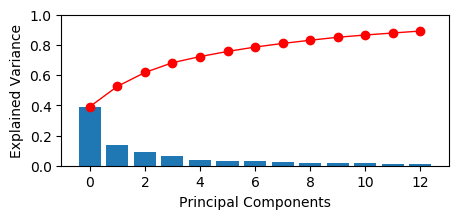

------------------------
pc shape: 104184 x 11
11 principal components
Variance retained 86.56%


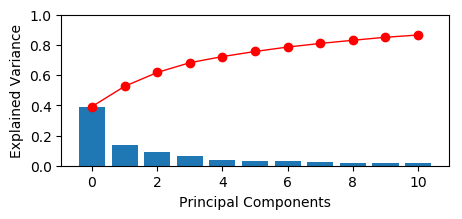

------------------------
pc shape: 104184 x 9
9 principal components
Variance retained 83.09%


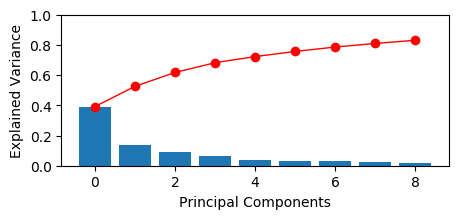

------------------------
pc shape: 104184 x 7
7 principal components
Variance retained 78.59%


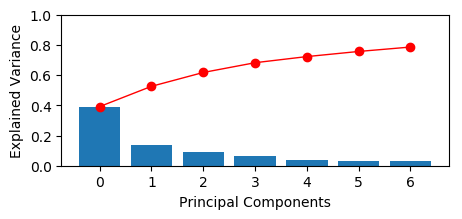

------------------------
pc shape: 104184 x 5
5 principal components
Variance retained 72.27%


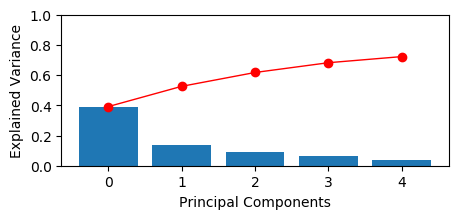

------------------------
pc shape: 104184 x 3
3 principal components
Variance retained 61.75%


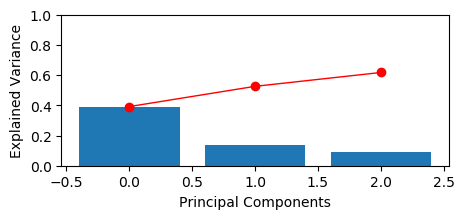

------------------------
pc shape: 104184 x 2
2 principal components
Variance retained 52.57%


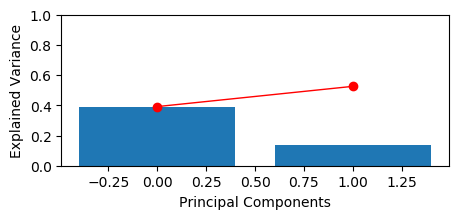

In [20]:
pcaplot(dim_32_labeled_data, n_comp = [13, 11, 9, 7, 5, 3, 2])

--- 0.20302581787109375 seconds ---


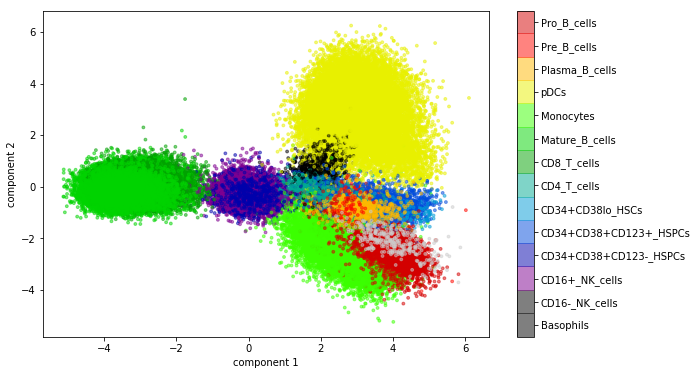

In [21]:
start_time_pca = time.time()
data_pca = pca(dim_32_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_pca))
Dim_Red_Plot (data_pca, dim_32_labels)

In [22]:
labeled_data_pca = addcluster(data_pca, dim_32_labels)

In [ ]:
matrix_pca = pd.DataFrame(data_pca).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_pca, [2, 3, 4, 5], [-0.25, 1], len(data_pca))

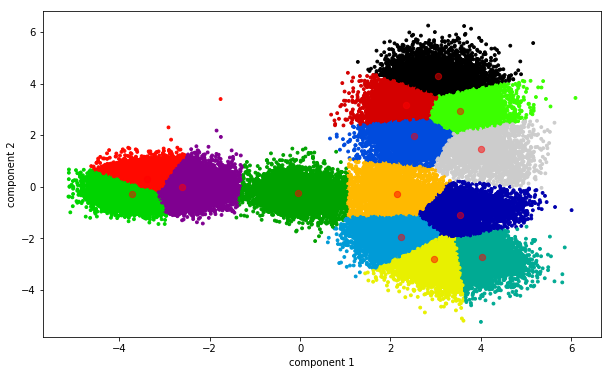

In [21]:
y_kmeans_pca , centers_pca = kmeans_pkg(data_pca, 14)
kmeans_plt (data_pca, y_kmeans_pca, centers_pca)

In [68]:
True_measures(data_pca, labeled_data_pca)

### True Cluster Membership

SSB : 352226.469945
Total_SSW : 77082.621603
Cluster-wise SSW:
Cluster 1: 789.260000
Cluster 2: 2356.690000
Cluster 3: 1244.260000
Cluster 4: 2749.450000
Cluster 5: 207.790000
Cluster 6: 556.210000
Cluster 7: 15323.470000
Cluster 8: 11814.520000
Cluster 9: 13269.990000
Cluster 10: 22615.780000
Cluster 11: 717.710000
Cluster 12: 202.140000
Cluster 13: 4834.820000
Cluster 14: 400.530000


In [23]:
new_measures(data_pca, 14)

### Class membership when K = 14

SSB : 354343.050406
Total_SSW : 51131.749974
Cluster-wise SSW:
Cluster 1: 1631.270000
Cluster 2: 3206.490000
Cluster 3: 4083.040000
Cluster 4: 7369.790000
Cluster 5: 2488.630000
Cluster 6: 2575.130000
Cluster 7: 5323.970000
Cluster 8: 2987.150000
Cluster 9: 5658.390000
Cluster 10: 2738.350000
Cluster 11: 4054.100000
Cluster 12: 3531.700000
Cluster 13: 1938.840000
Cluster 14: 3544.900000

Iteration till convergence : 62


In [48]:
#table_pca = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_pca, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (PCA)')
#table_pca

In [47]:
#No_of_Misclassified_Cells_pca = table_pca.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (PCA)')
#No_of_Misclassified_Cells_pca

In [46]:
#printmd('### Coverage Matrix for k=3 (PCA)')
#coverage_matrix_pca = table_pca.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_pca

In [45]:
#print('total coverage for PCA : %f' % (coverage_matrix_pca.values.sum()/(len(table_pca)*3)))

In [24]:
accuracy_pca = accuracycalculation (data_pca)
printmd('### Accuracy Matrix (PCA-Kmeans)')
accuracy_pca

### Accuracy Matrix (PCA-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,94.20
2,3,90.26
3,4,93.03
4,5,91.38
5,6,84.25
6,7,78.28
7,8,76.02
8,9,75.32
9,10,67.16


In [25]:
print("F1-Score for PCA-Kmeans =", F1_measure(dim_32_labels, y_kmeans_pca))

F1-Score for PCA-Kmeans = 0.4257334482733594


In [26]:
print("Adjusted Rand index for PCA-Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans_pca))

Adjusted Rand index for PCA-Kmeans = 0.343398421681395


In [27]:
print("FMI for PCA-Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans_pca)) 

FMI for PCA-Kmeans = 0.44348193237622624


In [28]:
print("V-measure Score for PCA-Kmeans =", v_measure_score(dim_32_labels, y_kmeans_pca))

V-measure Score for PCA-Kmeans = 0.6090076179155928


# Factor Analysis (FA)

--- 2.6127288341522217 seconds ---


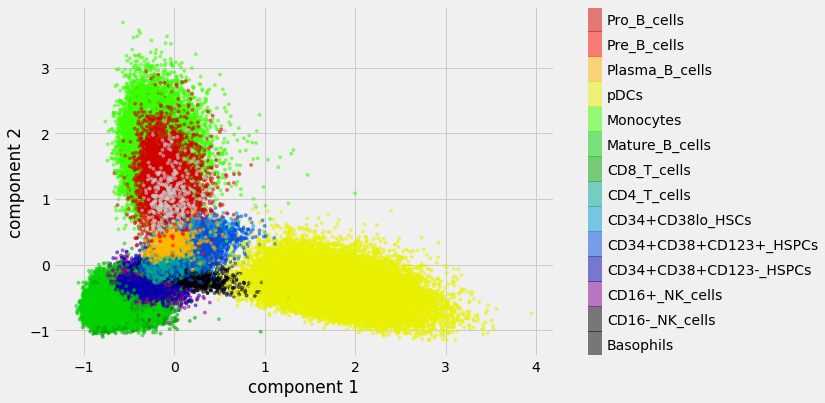

In [24]:
start_time_fa = time.time()
fa, data_fa = fa(dim_32_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_fa))
Dim_Red_Plot (data_fa, dim_32_labels)

## Analysis of FA

In [25]:
c2 = np.sum(fa.components_ ** 2, axis=1)
total_variance_ = np.sum(c2)
pvars_ = 100 * c2 / total_variance_
pvars_noise_ = 100 * c2 / (total_variance_ + np.sum(fa.noise_variance_))
print(' variance explained without noise =')
print(pvars_)
print('-'*40)
print(' variance explained with noise =')
print(pvars_noise_)

 variance explained without noise =
[51.87081205 48.12918795]
----------------------------------------
 variance explained with noise =
[23.59049507 21.88882969]


In [26]:
labeled_data_fa = addcluster(data_fa, dim_32_labels)

In [ ]:
matrix_fa = pd.DataFrame(data_fa).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.55, 1]
silhouette_plot(matrix_fa, [2, 3, 4, 5], [-0.55, 1], len(data_fa))

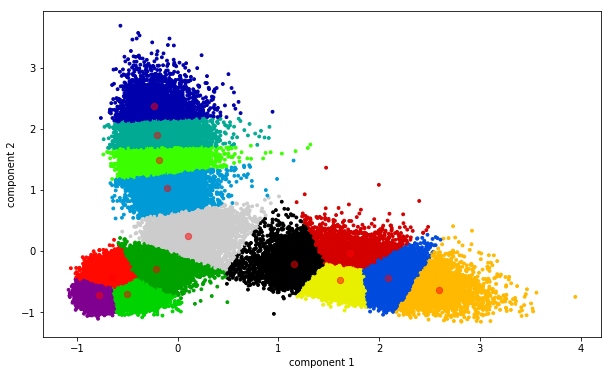

In [32]:
y_kmeans_fa , centers_fa = kmeans_pkg(data_fa, 14)
kmeans_plt (data_fa, y_kmeans_fa, centers_fa)

In [69]:
True_measures(data_fa, labeled_data_fa)

### True Cluster Membership

SSB : 126353.615454
Total_SSW : 29746.300133
Cluster-wise SSW:
Cluster 1: 302.070000
Cluster 2: 752.560000
Cluster 3: 432.860000
Cluster 4: 900.910000
Cluster 5: 76.670000
Cluster 6: 187.610000
Cluster 7: 4722.240000
Cluster 8: 3724.720000
Cluster 9: 6478.070000
Cluster 10: 9508.760000
Cluster 11: 232.520000
Cluster 12: 117.390000
Cluster 13: 2138.680000
Cluster 14: 171.240000


In [34]:
new_measures(data_fa, 14)

### Class membership when K = 14

SSB : 126219.454720
Total_SSW : 20122.771379
Cluster-wise SSW:
Cluster 1: 834.260000
Cluster 2: 1119.510000
Cluster 3: 997.470000
Cluster 4: 0.000000
Cluster 5: 735.800000
Cluster 6: 1914.560000
Cluster 7: 1032.230000
Cluster 8: 3337.040000
Cluster 9: 679.950000
Cluster 10: 1038.950000
Cluster 11: 855.680000
Cluster 12: 1202.410000
Cluster 13: 5330.870000
Cluster 14: 1044.020000

Iteration till convergence : 124


In [75]:
#table_fa = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_fa, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (FA)')
#table_fa

In [74]:
#No_of_Misclassified_Cells_fa = table_fa.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (FA)')
#No_of_Misclassified_Cells_fa

In [73]:
#printmd('### Coverage Matrix for k=3 (FA)')
#coverage_matrix_fa = table_fa.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_fa

In [72]:
#print('total coverage for FA : %f' % (coverage_matrix_fa.values.sum()/(len(table_fa)*3)))

In [35]:
accuracy_fa = accuracycalculation (data_fa)
printmd('### Accuracy Matrix (FA-Kmeans)')
accuracy_fa

### Accuracy Matrix (FA-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,99.53
2,3,93.52
3,4,90.47
4,5,87.62
5,6,83.91
6,7,81.57
7,8,80.56
8,9,79.00
9,10,75.41


In [36]:
print("F1-Score for FA-Kmeans =", F1_measure(dim_32_labels, y_kmeans_fa))

F1-Score for FA-Kmeans = 0.42053504386869156


In [37]:
print("Adjusted Rand index for FA-Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans_fa))

Adjusted Rand index for FA-Kmeans = 0.3297198642813875


In [38]:
print("FMI for FA-Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans_fa)) 

FMI for FA-Kmeans = 0.43131009882356913


In [39]:
print("V-measure Score for FA-Kmeans =", v_measure_score(dim_32_labels, y_kmeans_fa))

V-measure Score for FA-Kmeans = 0.5817466914672562


# Independent Component Analysis (ICA)

--- 0.20539212226867676 seconds ---


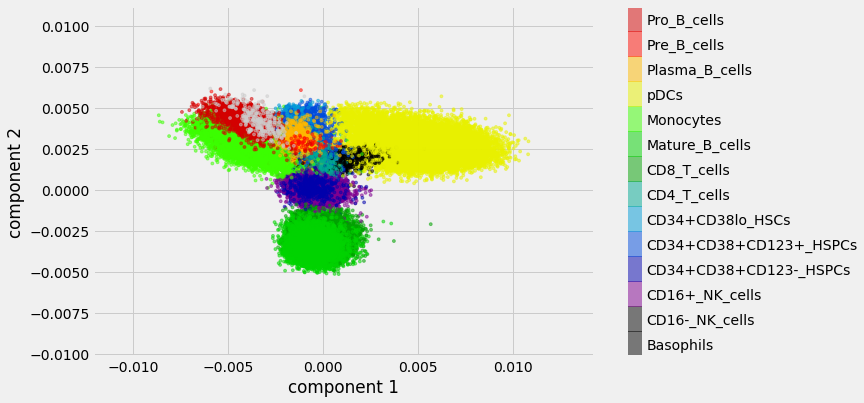

In [27]:
start_time_ica = time.time()
data_ica = ica(dim_32_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_ica))
Dim_Red_Plot (data_ica, dim_32_labels)

In [28]:
labeled_data_ica = addcluster(data_ica, dim_32_labels)

In [ ]:
matrix_ica = pd.DataFrame(data_ica).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.4, 1]
silhouette_plot(matrix_ica, [2, 3, 4, 5], [-0.4, 1], len(data_ica))

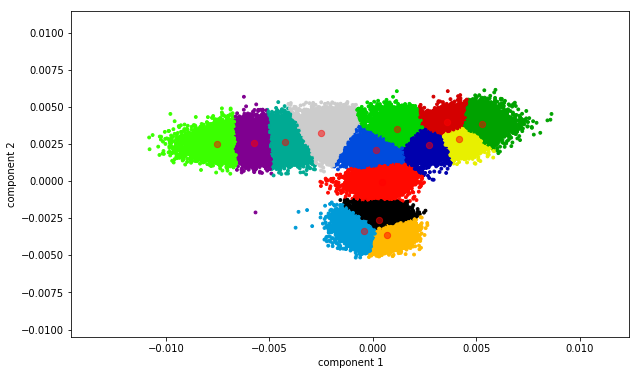

In [42]:
y_kmeans_ica , centers_ica = kmeans_pkg(data_ica, 14)
kmeans_plt (data_ica, y_kmeans_ica, centers_ica)

In [70]:
True_measures(data_ica, labeled_data_ica)

### True Cluster Membership

SSB : 413.857016
Total_SSW : 104.000985
Cluster-wise SSW:
Cluster 1: 1.170000
Cluster 2: 3.110000
Cluster 3: 1.650000
Cluster 4: 3.320000
Cluster 5: 0.250000
Cluster 6: 0.690000
Cluster 7: 19.540000
Cluster 8: 15.140000
Cluster 9: 18.370000
Cluster 10: 32.510000
Cluster 11: 0.890000
Cluster 12: 0.290000
Cluster 13: 6.550000
Cluster 14: 0.520000


In [44]:
new_measures(data_ica, 14)

### Class membership when K = 14

SSB : 416.786522
Total_SSW : 71.966144
Cluster-wise SSW:
Cluster 1: 7.620000
Cluster 2: 4.020000
Cluster 3: 4.410000
Cluster 4: 0.000000
Cluster 5: 4.510000
Cluster 6: 2.680000
Cluster 7: 11.610000
Cluster 8: 6.160000
Cluster 9: 10.650000
Cluster 10: 0.000000
Cluster 11: 6.400000
Cluster 12: 4.700000
Cluster 13: 5.710000
Cluster 14: 3.500000

Iteration till convergence : 149


In [71]:
#table_ica = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_ica, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (ICA)')
#table_ica

In [70]:
#No_of_Misclassified_Cells_ica = table_ica.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (ICA)')
#No_of_Misclassified_Cells_ica

In [69]:
#printmd('### Coverage Matrix for k=3 (ICA)')
#coverage_matrix_ica = table_ica.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_ica

In [68]:
#print('total coverage for ICA : %f' % (coverage_matrix_ica.values.sum()/(len(table_ica)*3)))

In [45]:
accuracy_ica = accuracycalculation (data_ica)
printmd('### Accuracy Matrix (ICA-Kmeans)')
accuracy_ica

### Accuracy Matrix (ICA-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,94.19
2,3,93.85
3,4,90.46
4,5,86.05
5,6,83.30
6,7,77.52
7,8,71.52
8,9,71.59
9,10,69.63


In [46]:
print("F1-Score for ICA-Kmeans =", F1_measure(dim_32_labels, y_kmeans_ica))

F1-Score for ICA-Kmeans = 0.4313939015105501


In [47]:
print("Adjusted Rand index for ICA-Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans_ica))

Adjusted Rand index for ICA-Kmeans = 0.3489595028221068


In [48]:
print("FMI for ICA-Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans_ica)) 

FMI for ICA-Kmeans = 0.44843386487657033


In [49]:
print("V-measure Score for ICA-Kmeans =", v_measure_score(dim_32_labels, y_kmeans_ica))

V-measure Score for ICA-Kmeans = 0.6108869843077491


# Singular Value Decomposition (SVD)

--- 0.15819716453552246 seconds ---


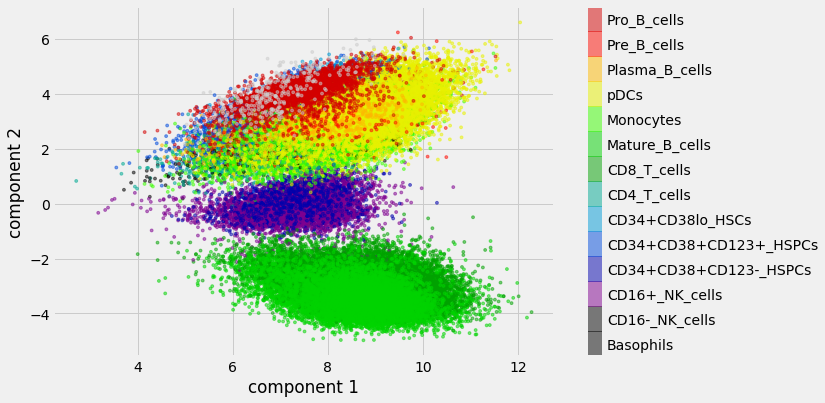

In [30]:
start_time_svd = time.time()
data_svd = svd(dim_32_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_svd))
Dim_Red_Plot (data_svd, dim_32_labels)

In [31]:
def svdplot(data, n_comp):
    printmd('### Analysis of SVD')
    # n_comp = [13, 11, 9, 7, 5, 3, 2]
    
    for i in range(len(n_comp)):
        svd = TruncatedSVD(n_components = n_comp[i])
        svd.fit(data)
        data_svd = svd.transform(data)
        svd_restored = svd.inverse_transform(data_svd)
        print('------------------------')
        print('pc shape: %d x %d' %data_svd.shape)
        print('%d principal components' % (n_comp[i]))
        print('Variance retained %.2f%%' % (sum(svd.explained_variance_ratio_) * 100))

        plt.figure(2, figsize=(5,2), dpi=100)
        xlab = ['SV %s' % j for j in list(range(0, n_comp[i]))]
        x = list(range(0, n_comp[i]))
        y = svd.explained_variance_ratio_
        ycum = y.cumsum()
        # grid(b=None, which='major', axis='both')
        plt.bar(x, y)
        plt.plot(x, ycum, c='red', marker='o', linewidth = 1)
        plt.axis(ymin=0, ymax=1)
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance')
        plt.show()

### Analysis of SVD

------------------------
pc shape: 104184 x 12
12 principal components
Variance retained 87.46%


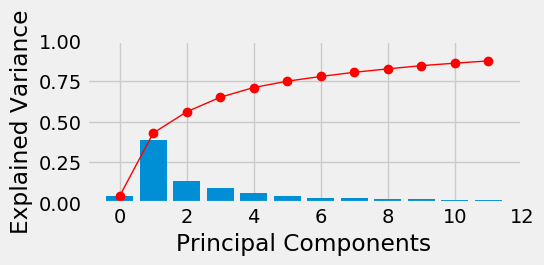

------------------------
pc shape: 104184 x 11
11 principal components
Variance retained 86.06%


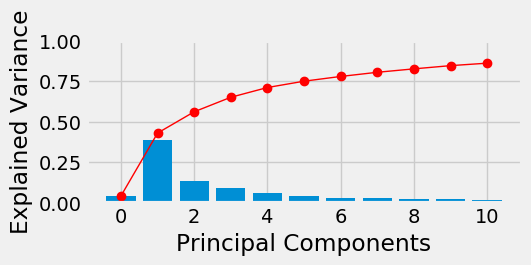

------------------------
pc shape: 104184 x 9
9 principal components
Variance retained 82.55%


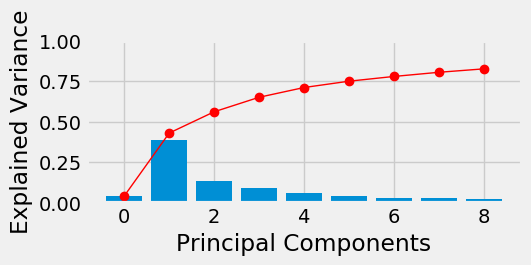

------------------------
pc shape: 104184 x 7
7 principal components
Variance retained 77.86%


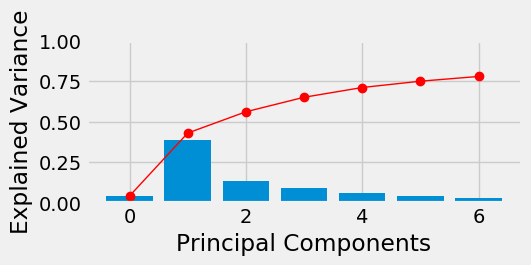

------------------------
pc shape: 104184 x 5
5 principal components
Variance retained 71.03%


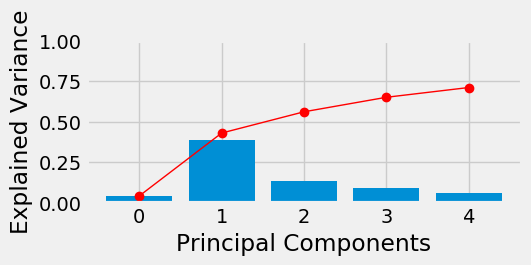

------------------------
pc shape: 104184 x 3
3 principal components
Variance retained 56.05%


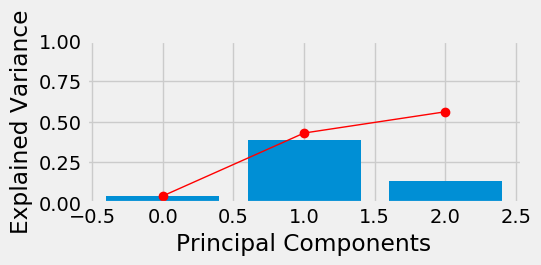

------------------------
pc shape: 104184 x 2
2 principal components
Variance retained 42.93%


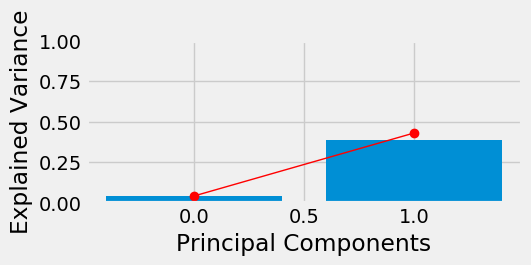

In [32]:
svdplot(dim_32_labeled_data, n_comp = [12, 11, 9, 7, 5, 3, 2])

In [33]:
labeled_data_svd = addcluster(data_svd, dim_32_labels)

In [ ]:
matrix_svd = pd.DataFrame(data_svd).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_svd, [2, 3, 4, 5], [-0.25, 1], len(data_svd))

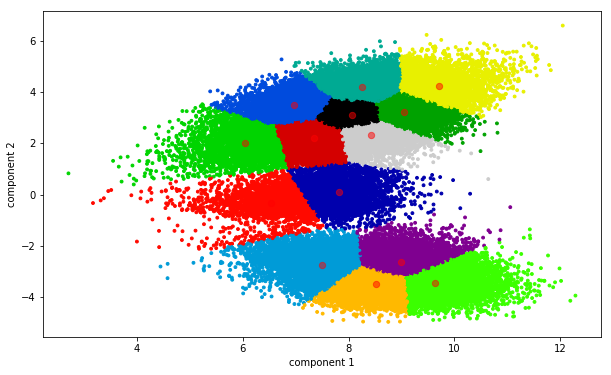

In [54]:
y_kmeans_svd , centers_svd = kmeans_pkg(data_svd, 14)
kmeans_plt (data_svd, y_kmeans_svd, centers_svd)

In [71]:
True_measures(data_svd, labeled_data_svd)

### True Cluster Membership

SSB : 315612.376906
Total_SSW : 93581.374514
Cluster-wise SSW:
Cluster 1: 1105.960000
Cluster 2: 3438.180000
Cluster 3: 1692.640000
Cluster 4: 3817.730000
Cluster 5: 309.060000
Cluster 6: 912.470000
Cluster 7: 21469.400000
Cluster 8: 16594.900000
Cluster 9: 15109.000000
Cluster 10: 21436.210000
Cluster 11: 1283.330000
Cluster 12: 341.450000
Cluster 13: 5574.290000
Cluster 14: 496.750000


In [56]:
new_measures(data_svd, 14)

### Class membership when K = 14

SSB : 323654.639048
Total_SSW : 62862.729820
Cluster-wise SSW:
Cluster 1: 0.000000
Cluster 2: 5569.150000
Cluster 3: 4338.920000
Cluster 4: 6704.720000
Cluster 5: 3549.340000
Cluster 6: 0.000000
Cluster 7: 3821.680000
Cluster 8: 12958.830000
Cluster 9: 16320.480000
Cluster 10: 5372.170000
Cluster 11: 0.000000
Cluster 12: 0.000000
Cluster 13: 4227.440000
Cluster 14: 0.000000

Iteration till convergence : 76


In [55]:
#table_svd = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_svd, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (SVD)')
#table_svd

In [56]:
#No_of_Misclassified_Cells_svd = table_svd.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (SVD)')
#No_of_Misclassified_Cells_svd

In [57]:
#printmd('### Coverage Matrix for k=3 (SVD)')
#coverage_matrix_svd = table_svd.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_svd

In [58]:
#print('total coverage for SVD : %f' % (coverage_matrix_svd.values.sum()/(len(table_svd)*3)))

In [57]:
accuracy_svd = accuracycalculation (data_svd)
printmd('### Accuracy Matrix (SVD-Kmeans)')
accuracy_svd

### Accuracy Matrix (SVD-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,94.27
2,3,83.87
3,4,76.85
4,5,70.65
5,6,61.95
6,7,59.83
7,8,58.64
8,9,53.89
9,10,52.41


In [58]:
print("F1-Score for SVD-Kmeans =", F1_measure(dim_32_labels, y_kmeans_svd))

F1-Score for SVD-Kmeans = 0.3218604383579287


In [59]:
print("Adjusted Rand index for SVD-Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans_svd))

Adjusted Rand index for SVD-Kmeans = 0.23164291775418322


In [60]:
print("FMI for SVD-Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans_svd)) 

FMI for SVD-Kmeans = 0.3404454332425258


In [61]:
print("V-measure Score for SVD-Kmeans =", v_measure_score(dim_32_labels, y_kmeans_svd))

V-measure Score for SVD-Kmeans = 0.44351036848265496


# t-distributed Stochastic Neighbor Embedding (t-SNE)

In [46]:
data_tsne = np.array(pd.read_csv('Reduced_dim_data/data_tsne_32dim.txt', sep = ",", header=-1))

--- 1576.4934630393982 seconds ---


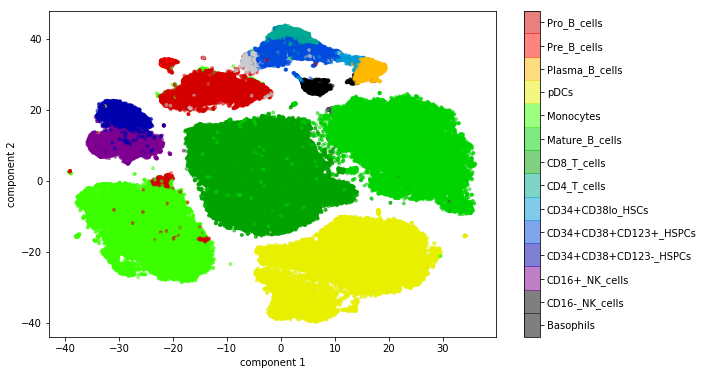

In [62]:
start_time_tsne = time.time()
data_tsne = tsne(dim_32_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_tsne))
Dim_Red_Plot (data_tsne, dim_32_labels)

In [63]:
#np.savetxt("data_tsne_32dim.txt", data_tsne, delimiter=",")

In [47]:
labeled_data_tsne = addcluster(data_tsne, dim_32_labels)

In [ ]:
matrix_tsne = pd.DataFrame(data_tsne).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_tsne, [5, 6, 7, 8, 9, 10, 11, 12], [-0.25, 1], len(data_tsne))

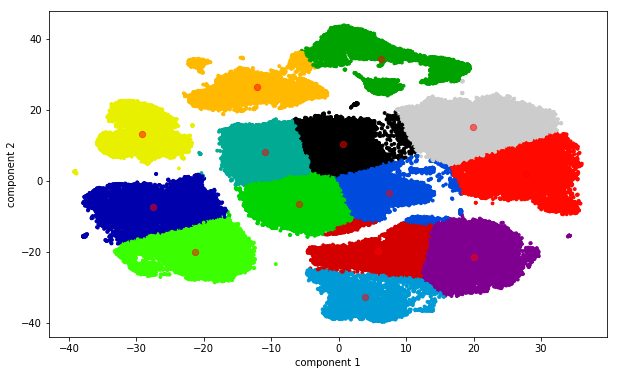

In [65]:
y_kmeans_tsne , centers_tsne = kmeans_pkg(data_tsne, 14)
kmeans_plt (data_tsne, y_kmeans_tsne, centers_tsne)

In [72]:
True_measures(data_tsne, labeled_data_tsne)

### True Cluster Membership

SSB : 2255811.149309
Total_SSW : 933893.070977
Cluster-wise SSW:
Cluster 1: 3336.070000
Cluster 2: 18361.120000
Cluster 3: 7014.490000
Cluster 4: 14555.240000
Cluster 5: 624.670000
Cluster 6: 1945.380000
Cluster 7: 274044.720000
Cluster 8: 199699.150000
Cluster 9: 151621.510000
Cluster 10: 218563.910000
Cluster 11: 2723.830000
Cluster 12: 787.690000
Cluster 13: 39548.810000
Cluster 14: 1066.500000


In [73]:
new_measures(data_tsne, 14)

### Class membership when K = 14

SSB : 2475706.127148
Total_SSW : 670052.456526
Cluster-wise SSW:
Cluster 1: 0.000000
Cluster 2: 142357.340000
Cluster 3: 42452.040000
Cluster 4: 35745.790000
Cluster 5: 51637.550000
Cluster 6: 29788.920000
Cluster 7: 58116.070000
Cluster 8: 30468.000000
Cluster 9: 35370.370000
Cluster 10: 71338.070000
Cluster 11: 39650.420000
Cluster 12: 35870.820000
Cluster 13: 41668.590000
Cluster 14: 55588.480000

Iteration till convergence : 58


In [59]:
#table_tsne = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_tsne, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (tsne)')
#table_tsne

In [60]:
#No_of_Misclassified_Cells_tsne = table_tsne.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (tsne)')
#No_of_Misclassified_Cells_tsne

In [61]:
#printmd('### Coverage Matrix for k=3 (tsne)')
#coverage_matrix_tsne = table_tsne.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_tsne

In [62]:
#print('total coverage for tsne : %f' % (coverage_matrix_tsne.values.sum()/(len(table_tsne)*3)))

In [74]:
accuracy_tsne = accuracycalculation (data_tsne)
printmd('### Accuracy Matrix (t_SNE-Kmeans)')
accuracy_tsne

### Accuracy Matrix (t_SNE-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,93.85
2,3,92.54
3,4,88.65
4,5,94.18
5,6,94.48
6,7,91.13
7,8,85.27
8,9,82.43
9,10,88.77


In [75]:
print("F1-Score for t_SNE-Kmeans =", F1_measure(dim_32_labels, y_kmeans_tsne))

F1-Score for t_SNE-Kmeans = 0.5292159370307


In [76]:
print("Adjusted Rand index for t_SNE-Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans_tsne))

Adjusted Rand index for t_SNE-Kmeans = 0.4745735734940683


In [77]:
print("FMI for t_SNE-Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans_tsne)) 

FMI for t_SNE-Kmeans = 0.5782325368209038


In [78]:
print("V-measure Score for t_SNE-Kmeans =", v_measure_score(dim_32_labels, y_kmeans_tsne))

V-measure Score for t_SNE-Kmeans = 0.7443213894674462


# Uniform Manifold Approximation and Projection (UMAP)

In [19]:
data_umap = np.array(pd.read_csv('Reduced_dim_data/data_umap_32dim.txt', sep = ",", header=-1))

--- 491.17169213294983 seconds ---


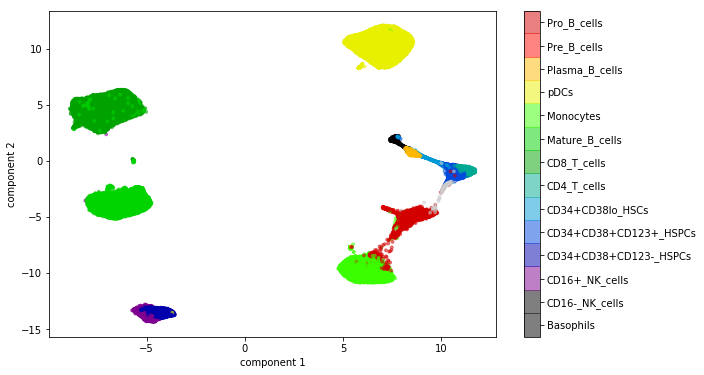

In [79]:
start_time_umap = time.time()
data_umap = u_map(dim_32_labeled_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_umap))
Dim_Red_Plot (data_umap, dim_32_labels)

In [80]:
#np.savetxt("data_umap_32dim.txt", data_umap, delimiter=",")

In [20]:
labeled_data_umap = addcluster(data_umap, dim_32_labels)

In [ ]:
matrix_umap = pd.DataFrame(data_umap).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.4, 1]
silhouette_plot(matrix_umap, [2, 3, 4, 5], [-0.4, 1], len(data_umap))

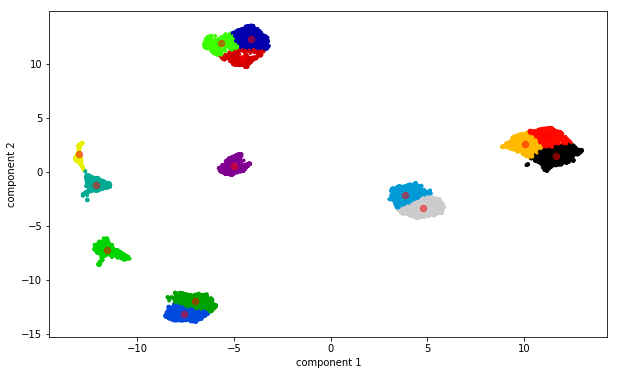

In [47]:
y_kmeans_umap , centers_umap = kmeans_pkg(data_umap, 14)
kmeans_plt (data_umap, y_kmeans_umap, centers_umap)

In [83]:
True_measures(data_umap, labeled_data_umap)

### True Cluster Membership

SSB : 1051688.879141
Total_SSW : 98894.562910
Cluster-wise SSW:
Cluster 1: 377.750000
Cluster 2: 2301.430000
Cluster 3: 850.970000
Cluster 4: 1709.660000
Cluster 5: 166.480000
Cluster 6: 198.820000
Cluster 7: 30029.020000
Cluster 8: 20892.500000
Cluster 9: 15229.130000
Cluster 10: 21985.570000
Cluster 11: 269.440000
Cluster 12: 97.860000
Cluster 13: 4575.490000
Cluster 14: 210.440000


In [120]:
new_measures(data_umap, 14)

### Class membership when K = 14

SSB : 1054190.211040
Total_SSW : 78756.662007
Cluster-wise SSW:
Cluster 1: 5575.510000
Cluster 2: 2025.510000
Cluster 3: 1898.040000
Cluster 4: 3046.840000
Cluster 5: 9022.070000
Cluster 6: 3694.510000
Cluster 7: 8049.190000
Cluster 8: 0.000000
Cluster 9: 10953.210000
Cluster 10: 1145.220000
Cluster 11: 4355.990000
Cluster 12: 9157.790000
Cluster 13: 19832.790000
Cluster 14: 0.000000

Iteration till convergence : 48


In [63]:
#table_umap = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_umap, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (UMAP)')
#table_umap

In [64]:
#No_of_Misclassified_Cells_umap = table_umap.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (UMAP)')
#No_of_Misclassified_Cells_umap

In [65]:
#printmd('### Coverage Matrix for k=3 (UMAP)')
#coverage_matrix_umap = table_umap.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_umap

In [66]:
#print('total coverage for UMAP : %f' % (coverage_matrix_umap.values.sum()/(len(table_umap)*3)))

In [121]:
accuracy_umap = accuracycalculation (data_umap)
printmd('### Accuracy Matrix (UMAP-Kmeans)')
accuracy_umap

### Accuracy Matrix (UMAP-Kmeans)

,# Clusters,Accuracy
0,1,100.00
1,2,100.00
2,3,97.09
3,4,98.46
4,5,99.30
5,6,99.23
6,7,99.15
7,8,96.78
8,9,93.31
9,10,90.07


In [48]:
print("F1-Score for UMAP-Kmeans =", F1_measure(dim_32_labels, y_kmeans_umap))

F1-Score for UMAP-Kmeans = 0.5926672404928087


In [49]:
print("Adjusted Rand index for UMAP-Kmeans =", adjusted_rand_score(dim_32_labels, y_kmeans_umap))

Adjusted Rand index for UMAP-Kmeans = 0.5426430347491304


In [50]:
print("FMI for UMAP-Kmeans =", fowlkes_mallows_score(dim_32_labels, y_kmeans_umap)) 

FMI for UMAP-Kmeans = 0.6379798413740324


In [51]:
print("V-measure Score for UMAP-Kmeans =", v_measure_score(dim_32_labels, y_kmeans_umap))

V-measure Score for UMAP-Kmeans = 0.7968645992957556


# IsoMap

In [26]:
sample_1 = dim_32_labeled.sample(n = 10000,replace="False").reset_index(drop=True)

sample_1_data = sample_1.drop('label', axis = 1)    # Data without Labels
sample_1_labels = pd.DataFrame(sample_1['label'])   # labels

In [28]:
start_time_isomap = time.time()
data_isomap = isomap(sample_1_data, 2)
print("--- %s seconds ---" % (time.time() - start_time_isomap))
#Dim_Red_Plot (data_isomap, dim_32_labels)

--- 64.65789222717285 seconds ---


In [ ]:
#start_time_isomap = time.time()
#data_isomap = isomap(dim_32_labeled_data, 2)
#print("--- %s seconds ---" % (time.time() - start_time_isomap))
#Dim_Red_Plot (data_isomap, dim_32_labels)

In [29]:
labeled_data_isomap = addcluster(data_isomap, dim_32_labels)

In [ ]:
matrix_isomap = pd.DataFrame(data_isomap).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.25, 1]
silhouette_plot(matrix_tsne, [5, 6, 7, 8, 9, 10, 11, 12], [-0.25, 1], len(data_isomap))

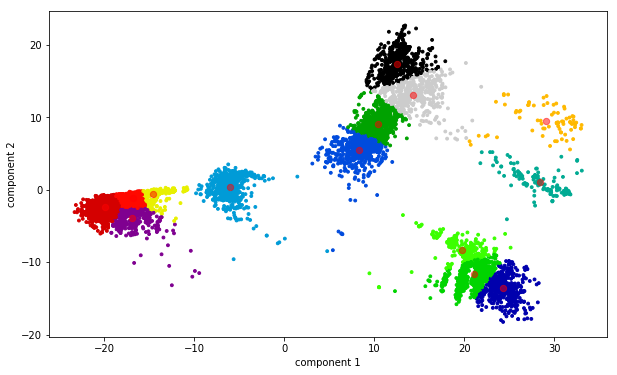

In [30]:
y_kmeans_isomap , centers_isomap = kmeans_pkg(data_isomap, 14)
kmeans_plt (data_isomap, y_kmeans_isomap, centers_isomap)

In [ ]:
True_measures(data_isomap, labeled_data_isomap)

In [ ]:
new_measures(data_isomap, 3)

In [ ]:
#table_isomap = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_isomap, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (Isomap)')
#table_isomap

In [ ]:
#No_of_Misclassified_Cells_isomap = table_isomap.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (Isomap)')
#No_of_Misclassified_Cells_isomap

In [ ]:
#printmd('### Coverage Matrix for k=3 (Isomap)')
#coverage_matrix_isomap = table_isomap.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_isomap

In [ ]:
#print('total coverage for isomap : %f' % (coverage_matrix_Isomap.values.sum()/(len(table_isomap)*3)))

In [ ]:
accuracy_isomap = accuracycalculation (data_isomap)
printmd('### Accuracy Matrix (Isomap)')
accuracy_isomap

In [40]:
print("F1-Score for Isomap-Kmeans =", F1_measure(sample_1_labels['label'], y_kmeans_isomap))

F1-Score for Isomap-Kmeans = 0.5577849976232355


In [42]:
print("Adjusted Rand index for Isomap-Kmeans =", adjusted_rand_score(sample_1_labels['label'], y_kmeans_isomap))

Adjusted Rand index for Isomap-Kmeans = 0.4964719869313215


In [43]:
print("FMI for Isomap-Kmeans =", fowlkes_mallows_score(sample_1_labels['label'], y_kmeans_isomap)) 

FMI for Isomap-Kmeans = 0.5844855081694939


In [44]:
print("V-measure Score for Isomap-Kmeans =", v_measure_score(sample_1_labels['label'], y_kmeans_isomap))

V-measure Score for Isomap-Kmeans = 0.7191030536671427


# MultiDimensional Scaling (MDS)

In [ ]:
data_mds = mds(dim_32_labeled_data, 2)
Dim_Red_Plot (data_mds, dim_32_labels)

In [ ]:
labeled_data_mds = addcluster(data_mds, dim_32_labels)

In [ ]:
matrix_mds = pd.DataFrame(data_mds).values
# The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.4, 1]
silhouette_plot(matrix_mds, [2, 3, 4, 5], [-0.4, 1], len(data_mds))

In [ ]:
y_kmeans_mds , centers_mds = kmeans_pkg(data_mds, 3)
kmeans_plt (data_mds, y_kmeans_mds, centers_mds)

In [ ]:
True_measures(data_mds, labeled_data_mds)

In [ ]:
new_measures(data_mds, 3)

In [ ]:
#table_mds = pd.crosstab(pd.Series(dim_32_labels, name = 'True Labels'), pd.Series(y_kmeans_mds, name = 'Assigned Label'))
#printmd('### Assigned Vs True Labels for k=3 (MDS)')
#table_mds

In [ ]:
#No_of_Misclassified_Cells_mds = table_mds.apply(lambda r: (r.sum()- r.max()), axis =1)
#printmd('### Number of Misclassified Cells for k=3 (MDS)')
#No_of_Misclassified_Cells_mds

In [ ]:
#printmd('### Coverage Matrix for k=3 (MDS)')
#coverage_matrix_mds = table_mds.apply(lambda r: round(r/r.sum(), 5), axis =0)
#coverage_matrix_mds

In [ ]:
#print('total coverage for MDS : %f' % (coverage_matrix_mds.values.sum()/(len(table_mds)*3)))

In [ ]:
accuracy_mds = accuracycalculation (data_mds)
printmd('### Accuracy Matrix (MDS)')
accuracy_mds

In [ ]:
print("FMI for MDS-Kmeans =", fowlkes_mallows_score(y_kmeans_fa, dim_32_labels)) 

In [ ]:
print("V-measure Score for MDS-Kmeans =", v_measure_score(y_kmeans_pca, dim_32_labels))

# Mixture Models

# PCA-Mixture_model

In [84]:
y_gmm_pca = Mixture_model(data_pca, 14)

In [85]:
print("F1-Score for PCA-Mixture_model =", F1_measure(dim_32_labels, y_gmm_pca))

F1-Score for PCA-Mixture_model = 0.49708243916304423


In [86]:
print("Adjusted Rand index for PCA-Mixture_model =", adjusted_rand_score(dim_32_labels, y_gmm_pca))

Adjusted Rand index for PCA-Mixture_model = 0.4056624326262762


In [87]:
print("FMI for PCA-Mixture_model =", fowlkes_mallows_score(dim_32_labels, y_gmm_pca)) 

FMI for PCA-Mixture_model = 0.500513510988986


In [88]:
print("V-measure Score for PCA-Mixture_model =", v_measure_score(dim_32_labels, y_gmm_pca))

V-measure Score for PCA-Mixture_model = 0.6360412266158413


In [89]:
accuracy_pca_gmm = accuracycalculation_gmm (data_pca)
printmd('### Accuracy Matrix (PCA and Mixture Model)')
accuracy_pca_gmm

### Accuracy Matrix (PCA and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,99.81
2,3,97.31
3,4,91.05
4,5,89.45
5,6,89.39
6,7,85.63
7,8,81.09
8,9,79.48
9,10,70.00


# FA-Mixture_model

In [90]:
y_gmm_fa = Mixture_model(data_fa, 14)

In [91]:
print("F1-Score for FA-Mixture_model =", F1_measure(dim_32_labels, y_gmm_fa))

F1-Score for FA-Mixture_model = 0.4457016162340131


In [92]:
print("Adjusted Rand index for FA-Mixture_model =", adjusted_rand_score(dim_32_labels, y_gmm_fa))

Adjusted Rand index for FA-Mixture_model = 0.3529798279391674


In [93]:
print("FMI for FA-Mixture_model =", fowlkes_mallows_score(dim_32_labels, y_gmm_fa)) 

FMI for FA-Mixture_model = 0.45287200023928276


In [94]:
print("V-measure Score for FA-Mixture_model =", v_measure_score(dim_32_labels, y_gmm_fa))

V-measure Score for FA-Mixture_model = 0.5890108820526854


In [95]:
accuracy_fa_gmm = accuracycalculation_gmm (data_fa)
printmd('### Accuracy Matrix (FA and Mixture Model)')
accuracy_fa_gmm

### Accuracy Matrix (FA and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,96.15
2,3,95.62
3,4,88.67
4,5,83.91
5,6,82.19
6,7,82.16
7,8,81.48
8,9,77.28
9,10,74.77


# ICA-Mixture_model

In [96]:
y_gmm_ica = Mixture_model(data_ica, 14)

In [97]:
print("F1-Score for ICA-Mixture_model =", F1_measure(dim_32_labels, y_gmm_ica))

F1-Score for ICA-Mixture_model = 0.6703256146976646


In [98]:
print("Adjusted Rand index for ICA-Mixture_model =", adjusted_rand_score(dim_32_labels, y_gmm_ica))

Adjusted Rand index for ICA-Mixture_model = 0.5724609490386517


In [99]:
print("FMI for ICA-Mixture_model =", fowlkes_mallows_score(dim_32_labels, y_gmm_ica)) 

FMI for ICA-Mixture_model = 0.7060806218312017


In [100]:
print("V-measure Score for ICA-Mixture_model =", v_measure_score(dim_32_labels, y_gmm_ica))

V-measure Score for ICA-Mixture_model = 0.6900804379855563


In [101]:
accuracy_ica_gmm = accuracycalculation_gmm (data_ica)
printmd('### Accuracy Matrix (ICA and Mixture Model)')
accuracy_ica_gmm

### Accuracy Matrix (ICA and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,94.92
2,3,93.52
3,4,93.12
4,5,93.81
5,6,93.81
6,7,93.66
7,8,91.86
8,9,87.83
9,10,82.55


# SVD-Mixture_model

In [102]:
y_gmm_svd = Mixture_model(data_svd, 14)

In [103]:
print("F1-Score for SVD-Mixture_model =", F1_measure(dim_32_labels, y_gmm_svd))

F1-Score for SVD-Mixture_model = 0.3126610017296964


In [104]:
print("Adjusted Rand index for SVD-Mixture_model =", adjusted_rand_score(dim_32_labels, y_gmm_svd))

Adjusted Rand index for SVD-Mixture_model = 0.2211935847226716


In [105]:
print("FMI for SVD-Mixture_model =", fowlkes_mallows_score(dim_32_labels, y_gmm_svd)) 

FMI for SVD-Mixture_model = 0.33069438276075913


In [106]:
print("V-measure Score for SVD-Mixture_model =", v_measure_score(dim_32_labels, y_gmm_svd))

V-measure Score for SVD-Mixture_model = 0.44335232673480435


In [107]:
accuracy_svd_gmm = accuracycalculation_gmm (data_svd)
printmd('### Accuracy Matrix (SVD and Mixture Model)')
accuracy_svd_gmm

### Accuracy Matrix (SVD and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,99.81
2,3,87.76
3,4,83.66
4,5,69.49
5,6,66.67
6,7,63.52
7,8,61.97
8,9,56.47
9,10,53.74


# t_SNE-Mixture_model

In [108]:
y_gmm_tsne = Mixture_model(data_tsne, 14)

In [109]:
print("F1-Score for t_SNE-Mixture_model =", F1_measure(dim_32_labels, y_gmm_tsne))

F1-Score for t_SNE-Mixture_model = 0.5848668160373021


In [110]:
print("Adjusted Rand index for t_SNE-Mixture_model =", adjusted_rand_score(dim_32_labels, y_gmm_tsne))

Adjusted Rand index for t_SNE-Mixture_model = 0.5342483968917363


In [111]:
print("FMI for t_SNE-Mixture_model =", fowlkes_mallows_score(dim_32_labels, y_gmm_tsne)) 

FMI for t_SNE-Mixture_model = 0.6311925937467169


In [112]:
print("V-measure Score for t_SNE-Mixture_model =", v_measure_score(dim_32_labels, y_gmm_tsne))

V-measure Score for t_SNE-Mixture_model = 0.785410782136246


In [113]:
accuracy_tsne_gmm = accuracycalculation_gmm (data_tsne)
printmd('### Accuracy Matrix (t_SNE and Mixture Model)')
accuracy_tsne_gmm

### Accuracy Matrix (t_SNE and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,96.29
2,3,93.89
3,4,92.65
4,5,97.77
5,6,92.45
6,7,89.62
7,8,91.81
8,9,88.98
9,10,85.70


# UMAP-Mixture_model

In [114]:
y_gmm_umap = Mixture_model(data_umap, 14)

In [115]:
print("F1-Score for UMAP-Mixture_model =", F1_measure(dim_32_labels, y_gmm_umap))

F1-Score for UMAP-Mixture_model = 0.6254514904239401


In [116]:
print("Adjusted Rand index for UMAP-Mixture_model =", adjusted_rand_score(dim_32_labels, y_gmm_umap))

Adjusted Rand index for UMAP-Mixture_model = 0.5769095756304113


In [117]:
print("FMI for UMAP-Mixture_model =", fowlkes_mallows_score(dim_32_labels, y_gmm_umap)) 

FMI for UMAP-Mixture_model = 0.6654050600852036


In [118]:
print("V-measure Score for UMAP-Mixture_model =", v_measure_score(dim_32_labels, y_gmm_umap))

V-measure Score for UMAP-Mixture_model = 0.806662688347331


In [119]:
accuracy_umap_gmm = accuracycalculation_gmm (data_umap)
printmd('### Accuracy Matrix (umap and Mixture Model)')
accuracy_umap_gmm

### Accuracy Matrix (umap and Mixture Model)

,# Components,Accuracy
0,1,100.00
1,2,100.00
2,3,99.99
3,4,99.68
4,5,99.82
5,6,99.63
6,7,99.15
7,8,97.23
8,9,93.78
9,10,90.59


# Isomap-Mixture_model

In [52]:
y_gmm_isomap = Mixture_model(data_isomap, 14)

In [54]:
print("F1-Score for Isomap-Mixture_model =", F1_measure(sample_1_labels['label'], y_gmm_isomap))

F1-Score for Isomap-Mixture_model = 0.5833752011689892


In [55]:
print("Adjusted Rand index for Isomap-Mixture_model =", adjusted_rand_score(sample_1_labels['label'], y_gmm_isomap))

Adjusted Rand index for Isomap-Mixture_model = 0.5178811106269509


In [56]:
print("FMI for Isomap-Mixture_model =", fowlkes_mallows_score(sample_1_labels['label'], y_gmm_isomap)) 

FMI for Isomap-Mixture_model = 0.5977128675766193


In [57]:
print("V-measure Score for Isomap-Mixture_model =", v_measure_score(sample_1_labels['label'], y_gmm_isomap))

V-measure Score for Isomap-Mixture_model = 0.719405259333783


In [ ]:
accuracy_umap_gmm = accuracycalculation_gmm (data_isomap)
printmd('### Accuracy Matrix (Isomap and Mixture Model)')
accuracy_umap_gmm

# 3-D Plotting

In [127]:
def Dim_Red_Plot_3d (data, labels):
    '''
    data = data_new
    labels =  dim_32_labels
    
    '''
    fig = pyplot.figure(figsize=(15,10))
    ax = Axes3D(fig)
    X = np.arange(-42, 42, 2)
    Y = np.arange(-42, 42, 2)
    X, Y = np.meshgrid(X, Y)

    ax.scatter(np.array(data)[:, 0], np.array(data)[:, 1], labels, c=labels, edgecolor='none', alpha=0.5,
               cmap=plt.cm.get_cmap('gist_ncar', 14))

    cmap = mpl.cm.gist_ncar
    #for i in range (1, 25):
    #    ax.plot_surface(X, Y, (X*0 + Y*0)+i , color=cmap(i / float(14)))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_zlabel('Label')
    pyplot.show()

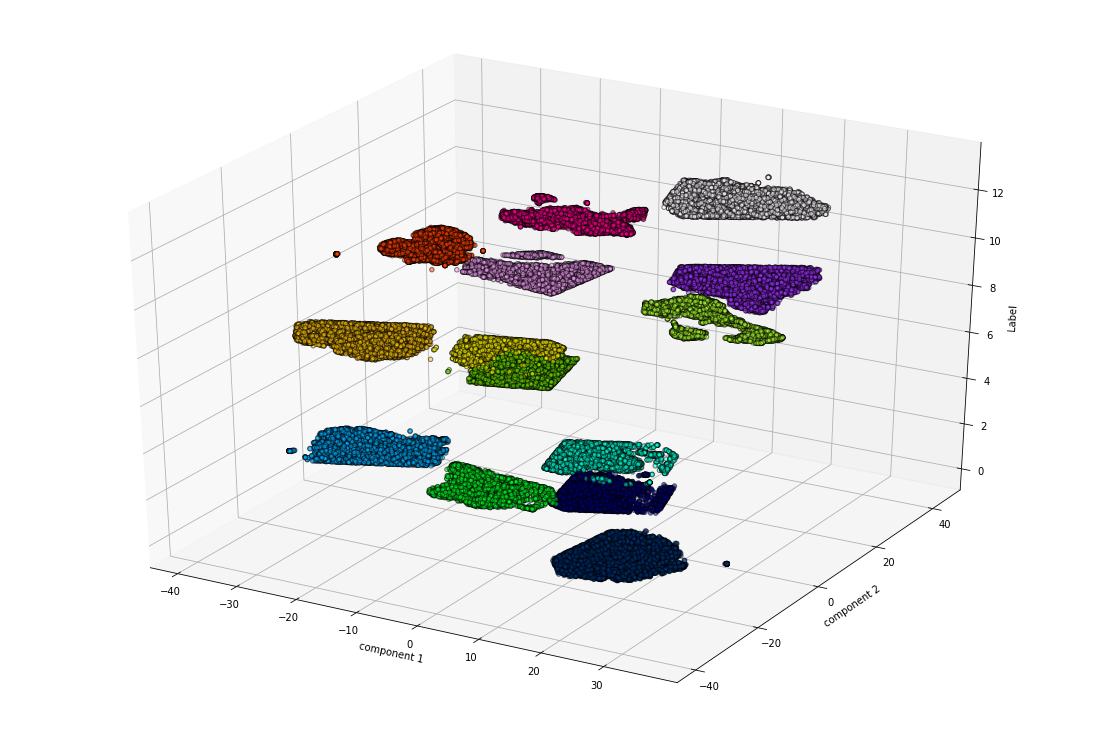

In [128]:
# Dim_Red_Plot_3d (data_tsne, dim_32_labels)
Dim_Red_Plot_3d (data_tsne, y_kmeans_tsne)

# Results on validation data

## PCA+K-means

In [26]:
val_pca = pca(validation_samples, 2)

In [27]:
y_kmeans_val_pca , centers_val_pca = kmeans_pkg(val_pca, 14)

In [28]:
print("F1-Score for PCA-Kmeans =", F1_measure(validation_labels, y_kmeans_val_pca))

F1-Score for PCA-Kmeans = 0.42798838602583805


## FA+K-means

In [29]:
fa, val_fa = fa(validation_samples, 2)

In [30]:
y_kmeans_val_fa , centers_val_fa = kmeans_pkg(val_fa, 14)

In [31]:
print("F1-Score for FA-Kmeans =", F1_measure(validation_labels, y_kmeans_val_fa))

F1-Score for FA-Kmeans = 0.41843348386310364


## ICA+K-means

In [32]:
val_ica = ica(validation_samples, 2)

In [33]:
y_kmeans_val_ica , centers_val_ica = kmeans_pkg(val_ica, 14)

In [34]:
print("F1-Score for ICA-Kmeans =", F1_measure(validation_labels, y_kmeans_val_ica))

F1-Score for ICA-Kmeans = 0.3975955337664567


## SVD+K-means

In [35]:
val_svd = svd(validation_samples, 2)

In [36]:
y_kmeans_val_svd , centers_val_svd = kmeans_pkg(val_svd, 14)

In [37]:
print("F1-Score for SVD-Kmeans =", F1_measure(validation_labels, y_kmeans_val_svd))

F1-Score for SVD-Kmeans = 0.30326330883455926


## t-SNE+K-means

In [38]:
val_tsne = tsne(validation_samples, 2)

In [39]:
np.savetxt("val_tsne_32dim.txt", val_tsne, delimiter=",")

In [40]:
y_kmeans_val_tsne , centers_val_tsne = kmeans_pkg(val_tsne, 14)

In [41]:
print("F1-Score for t-SNE-Kmeans =", F1_measure(validation_labels, y_kmeans_val_tsne))

F1-Score for t-SNE-Kmeans = 0.5697243989077211


## UMAP+K-means

In [43]:
val_umap = u_map(validation_samples, 2)

In [44]:
np.savetxt("val_umap_32dim.txt", val_umap, delimiter=",")

In [45]:
y_kmeans_val_umap , centers_val_umap = kmeans_pkg(val_umap, 14)

In [46]:
print("F1-Score for UMAP-Kmeans =", F1_measure(validation_labels, y_kmeans_val_umap))

F1-Score for UMAP-Kmeans = 0.5988165729796612


## HDBSCAN

## PCA-HDBSCAN

In [48]:
y_HDBSCAN_pca = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_pca)

In [60]:
print("F1-Score for PCA-HDBSCAN =", F1_measure(dim_32_labels, y_HDBSCAN_pca))

F1-Score for PCA-HDBSCAN = 0.6684508642769956


In [61]:
print("Adjusted Rand index for PCA-HDBSCAN =", adjusted_rand_score(dim_32_labels, y_HDBSCAN_pca))

Adjusted Rand index for PCA-HDBSCAN = 0.5732920009186232


In [62]:
print("FMI for PCA-HDBSCAN =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN_pca)) 

FMI for PCA-HDBSCAN = 0.6963749697282421


In [63]:
print("V-measure Score for PCA-HDBSCAN =", v_measure_score(dim_32_labels, y_HDBSCAN_pca))

V-measure Score for PCA-HDBSCAN = 0.6983784313657464


## FA-HDBSCAN

In [55]:
y_HDBSCAN_fa = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_fa)

In [64]:
print("F1-Score for FA-HDBSCAN =", F1_measure(dim_32_labels, y_HDBSCAN_fa))

F1-Score for FA-HDBSCAN = 0.6496096544625938


In [65]:
print("Adjusted Rand index for FA-HDBSCAN =", adjusted_rand_score(dim_32_labels, y_HDBSCAN_fa))

Adjusted Rand index for FA-HDBSCAN = 0.547428241606933


In [66]:
print("FMI for FA-HDBSCAN =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN_fa)) 

FMI for FA-HDBSCAN = 0.6801425616369374


In [67]:
print("V-measure Score for FA-HDBSCAN =", v_measure_score(dim_32_labels, y_HDBSCAN_fa))

V-measure Score for FA-HDBSCAN = 0.6571421958103785


## ICA-HDBSCAN

In [68]:
y_HDBSCAN_ica = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_ica)

In [69]:
print("F1-Score for ICA-HDBSCAN =", F1_measure(dim_32_labels, y_HDBSCAN_ica))

F1-Score for ICA-HDBSCAN = 0.6646978903722901


In [70]:
print("Adjusted Rand index for ICA-HDBSCAN =", adjusted_rand_score(dim_32_labels, y_HDBSCAN_ica))

Adjusted Rand index for ICA-HDBSCAN = 0.5689341252128861


In [71]:
print("FMI for ICA-HDBSCAN =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN_ica)) 

FMI for ICA-HDBSCAN = 0.6914468100766202


In [72]:
print("V-measure Score for ICA-HDBSCAN =", v_measure_score(dim_32_labels, y_HDBSCAN_ica))

V-measure Score for ICA-HDBSCAN = 0.6913319823971084


## SVD-HDBSCAN

In [73]:
y_HDBSCAN_svd = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_svd)

In [74]:
print("F1-Score for SVD-HDBSCAN =", F1_measure(dim_32_labels, y_HDBSCAN_svd))

F1-Score for SVD-HDBSCAN = 0.560389211048368


In [75]:
print("Adjusted Rand index for SVD-HDBSCAN =", adjusted_rand_score(dim_32_labels, y_HDBSCAN_svd))

Adjusted Rand index for SVD-HDBSCAN = 0.4166559758347091


In [76]:
print("FMI for SVD-HDBSCAN =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN_svd)) 

FMI for SVD-HDBSCAN = 0.6158154535617673


In [77]:
print("V-measure Score for SVD-HDBSCAN =", v_measure_score(dim_32_labels, y_HDBSCAN_svd))

V-measure Score for SVD-HDBSCAN = 0.5645265575522725


## t_SNE-HDBSCAN

In [78]:
y_HDBSCAN_tsne = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_tsne)

In [79]:
print("F1-Score for tsne-HDBSCAN =", F1_measure(dim_32_labels, y_HDBSCAN_tsne))

F1-Score for tsne-HDBSCAN = 0.9225113686687257


In [80]:
print("Adjusted Rand index for tsne-HDBSCAN =", adjusted_rand_score(dim_32_labels, y_HDBSCAN_tsne))

Adjusted Rand index for tsne-HDBSCAN = 0.9069476140821615


In [81]:
print("FMI for tsne-HDBSCAN =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN_tsne)) 

FMI for tsne-HDBSCAN = 0.9232402822182755


In [82]:
print("V-measure Score for tsne-HDBSCAN =", v_measure_score(dim_32_labels, y_HDBSCAN_tsne))

V-measure Score for tsne-HDBSCAN = 0.8983004276434059


## UMAP-HDBSCAN

In [21]:
y_HDBSCAN_umap = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_umap)

In [84]:
print("F1-Score for umap-HDBSCAN =", F1_measure(dim_32_labels, y_HDBSCAN_umap))

F1-Score for umap-HDBSCAN = 0.9813461618688906


In [85]:
print("Adjusted Rand index for umap-HDBSCAN =", adjusted_rand_score(dim_32_labels, y_HDBSCAN_umap))

Adjusted Rand index for umap-HDBSCAN = 0.9773677763184293


In [86]:
print("FMI for umap-HDBSCAN =", fowlkes_mallows_score(dim_32_labels, y_HDBSCAN_umap)) 

FMI for umap-HDBSCAN = 0.9813878895828799


In [87]:
print("V-measure Score for umap-HDBSCAN =", v_measure_score(dim_32_labels, y_HDBSCAN_umap))

V-measure Score for umap-HDBSCAN = 0.9518744456925012


# ISOMAP-HDBSCAN

In [59]:
y_HDBSCAN_isomap = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(data_isomap)

In [60]:
print("F1-Score for isomap-HDBSCAN =", F1_measure(sample_1_labels['label'], y_HDBSCAN_isomap))

F1-Score for isomap-HDBSCAN = 0.7045652801519531


In [61]:
print("Adjusted Rand index for isomap-HDBSCAN =", adjusted_rand_score(sample_1_labels['label'], y_HDBSCAN_isomap))

Adjusted Rand index for isomap-HDBSCAN = 0.619419318901782


In [62]:
print("V-measure Score for isomap-HDBSCAN =", v_measure_score(sample_1_labels['label'], y_HDBSCAN_isomap))

V-measure Score for isomap-HDBSCAN = 0.7689534874573364


In [7]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(dim_32_labeled_data)

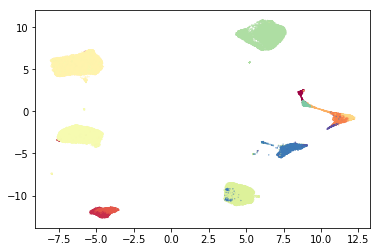

In [8]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=dim_32_labels, s=0.1, cmap='Spectral');

In [9]:
clusterable_embedding

array([[ 8.833585 ,  1.1166594],
       [ 8.670792 ,  2.3666463],
       [ 8.823306 ,  1.1416982],
       ...,
       [10.744286 , -1.7641623],
       [10.704104 , -1.8009292],
       [10.629295 , -1.8718517]], dtype=float32)

In [10]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [ ]:
F1_measure(dim_32_labels, labels)